参考：

统计学习方法，李航博士

https://cuijiahua.com/blog/2017/11/ml_9_svm_2.html

上篇文章讲解的是线性SVM的推导过程以及简化版SMO算法的代码实现。本篇文章将讲解SMO算法的优化方法以及非线性SVM。

# SMO算法优化
在几百个点组成的小规模数据集上，简化版SMO算法的运行是没有什么问题的，但是在更大的数据集上的运行速度就会变慢。简化版SMO算法的第二个α的选择是随机的，针对这一问题，我们可以使用启发式选择第二个α值，来达到优化效果。
## 启发选择方式
下面这两个公式想必已经不再陌生：![jupyter](./img/svm7-1.png)在实现SMO算法的时候，先计算η，再更新αj。为了加快第二个αj乘子的迭代速度，需要让直线的斜率增大，对于αj的更新公式，其中η值没有什么文章可做，于是只能令:$max|E_i-E_j|$

因此，我们可以明确自己的优化方法了：
1)最外层循环，首先在样本中选择违反KKT条件的一个乘子作为最外层循环，然后用"启发式选择"选择另外一个乘子并进行这两个乘子的优化
2)在非边界乘子中寻找使得 |Ei - Ej| 最大的样本
如果没有找到，则从整个样本中随机选择一个样本
接下来，让我们看看完整版SMO算法如何实现。
## 完整版SMO算法
完整版Platt SMO算法是通过一个外循环来选择违反KKT条件的一个乘子，并且其选择过程会在这两种方式之间进行交替：
1)在所有数据集上进行单遍扫描
2)在非边界α中实现单遍扫描
非边界α指的就是那些不等于边界0或C的α值，并且跳过那些已知的不会改变的α值。所以我们要先建立这些α的列表，用于才能出α的更新状态。
在选择第一个α值后，算法会通过"启发选择方式"选择第二个α值。
## 编写代码
我们首先构建一个仅包含init方法的optStruct类，将其作为一个数据结构来使用，方便我们对于重要数据的维护。代码思路和之前的简化版SMO算法是相似的，不同之处在于增加了优化方法，如果上篇文章已经看懂，我想这个代码会很好理解。创建一个svm-smo.py文件，编写代码如下：

L==H
全样本遍历:第0次迭代 样本:0, alpha优化次数:0
L==H
全样本遍历:第0次迭代 样本:1, alpha优化次数:0
全样本遍历:第0次迭代 样本:2, alpha优化次数:1
L==H
全样本遍历:第0次迭代 样本:3, alpha优化次数:1
全样本遍历:第0次迭代 样本:4, alpha优化次数:2
全样本遍历:第0次迭代 样本:5, alpha优化次数:2
全样本遍历:第0次迭代 样本:6, alpha优化次数:2
alpha_j变化太小
全样本遍历:第0次迭代 样本:7, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:8, alpha优化次数:2
全样本遍历:第0次迭代 样本:9, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:10, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:11, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:12, alpha优化次数:2
全样本遍历:第0次迭代 样本:13, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:14, alpha优化次数:2
全样本遍历:第0次迭代 样本:15, alpha优化次数:2
全样本遍历:第0次迭代 样本:16, alpha优化次数:2
L==H
全样本遍历:第0次迭代 样本:17, alpha优化次数:2
全样本遍历:第0次迭代 样本:18, alpha优化次数:3
全样本遍历:第0次迭代 样本:19, alpha优化次数:3
全样本遍历:第0次迭代 样本:20, alpha优化次数:3
全样本遍历:第0次迭代 样本:21, alpha优化次数:3
alpha_j变化太小
全样本遍历:第0次迭代 样本:22, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:23, alpha优化次数:3
L==H
全样本遍历:第0次迭代 样本:24, alpha优化次数:3
全样本遍历:第0次迭代 样本:25, alpha优化次数:4
alpha_j变化太小
全样本遍历:第0次迭代 样本:26, alpha优化次数:4
全样本遍历:第0次迭代 样本:27, alpha优化次数:4
全样本遍历:第0次迭代 样本:28, alpha优化次数:4
L==H
全样本遍历:第0次迭代 样本:

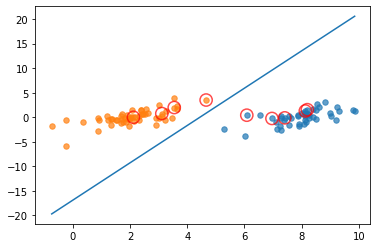

In [1]:
# -*-coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import random

#在下面添加此代码以显示单元格中的所有输出
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

class optStruct:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
    """
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
 
def loadDataSet(fileName):
    """
    读取数据
    Parameters:
        fileName - 文件名
    Returns:
        dataMat - 数据矩阵
        labelMat - 数据标签
    """
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat
 
def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T) + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
 
def selectJrand(i, m):
    """
    函数说明:随机选择alpha_j的索引值
 
    Parameters:
        i - alpha_i的索引值
        m - alpha参数个数
    Returns:
        j - alpha_j的索引值
    """
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j
 
def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej
 
def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存
 
 
def clipAlpha(aj,H,L):
    """
    修剪alpha_j
    Parameters:
        aj - alpha_j的值
        H - alpha上限
        L - alpha下限
    Returns:
        aj - 修剪后的alpah_j的值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj
 
def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.X[i,:] * oS.X[j,:].T - oS.X[i,:] * oS.X[i,:].T - oS.X[j,:] * oS.X[j,:].T
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0
 
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    """
    完整的线性SMO算法
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        maxIter - 最大迭代次数
    Returns:
        oS.b - SMO算法计算的b
        oS.alphas - SMO算法计算的alphas
    """
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler)                    #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas
 
 
def showClassifer(dataMat, classLabels, w, b):
    """
    分类结果可视化
    Parameters:
        dataMat - 数据矩阵
        w - 直线法向量
        b - 直线解决
    Returns:
        无
    """
    #绘制样本点
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if classLabels[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1], s=30, alpha=0.7)   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1], s=30, alpha=0.7) #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()
 
 
def calcWs(alphas,dataArr,classLabels):
    """
    计算w
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        alphas - alphas值
    Returns:
        w - 计算得到的w
    """
    X = np.mat(dataArr); labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w
 
if __name__ == '__main__':
    dataArr, classLabels = loadDataSet('./DataSet/SvmtestSet2.txt')
    b, alphas = smoP(dataArr, classLabels, 0.6, 0.001, 40)
    w = calcWs(alphas,dataArr, classLabels)
    showClassifer(dataArr, classLabels, w, b)

图中画红圈的样本点为支持向量上的点，是满足算法的一种解。完整版SMO算法覆盖整个数据集进行计算，而简化版SMO算法是随机选择的。可以看出，完整版SMO算法选出的支持向量样点更多，更接近理想的分隔超平面。![jupyter](./img/svm7-2.png)

对比两种算法的运算时间，我的测试结果是完整版SMO算法的速度比简化版SMO算法的速度快6倍左右。

其实，优化方法不仅仅是简单的启发式选择，还有其他优化方法，SMO算法速度还可以进一步提高。但是鉴于文章进度，这里不再进行展开。

# 非线性SVM
## 核技巧
我们已经了解到，SVM如何处理线性可分的情况，而对于非线性的情况，SVM的处理方式就是选择一个核函数。简而言之：在线性不可分的情况下，SVM通过某种事先选择的**非线性映射（核函数）**将输入变量映到一个高维特征空间，将其变成在高维空间线性可分，在这个高维空间中构造最优分类超平面。
根据上篇文章，线性可分的情况下，可知最终的超平面方程为：$$f(x)=\sum_{i=1}^na_iy_ix_i^Tx+b$$用内积表示$$f(x)=\sum_{i=1}^na_iy_i<x_i,x>+b$$

对于线性不可分，我们使用一个非线性映射，将数据映射到特征空间，在特征空间中使用线性学习器，分类函数变形如下：![jupyter](./img/svm7-3.png)

其中ϕ从输入空间(X)到某个特征空间(F)的映射，这意味着建立非线性学习器分为两步：

1)首先**使用一个非线性映射将数据变换到一个特征空间F**；

2)然后**在特征空间使用线性学习器分类**。

如果有一种方法可以在特征空间中直接计算内积 <ϕ(xi),ϕ(x)>，就像在原始输入点的函数中一样，就有可能将两个步骤融合到一起建立一个分线性的学习器，这样直接计算的方法称为**核函数方法**。

这里直接给出一个定义：**核是一个函数k，对所有x,z∈X，满足k(x,z)=<ϕ(xi),ϕ(x)>，这里ϕ(·)是从原始输入空间X到内积空间F的映射**。

简而言之：如果不是用核技术，就会先计算线性映ϕ(x1)和ϕ(x2)，然后计算它们的内积，使用了核技术之后，先把ϕ(x1)和ϕ(x2)的一般表达式<ϕ(x1),ϕ(x2)>=k(<ϕ(x1),ϕ(x2) >)计算出来，这里的<·，·>表示内积，k(·，·)就是对应的核函数，这个表达式往往非常简单，所以计算非常方便。

这种将内积替换成核函数的方式被称为**核技巧(kernel trick)**。

## 非线性数据处理
已经知道了核技巧是什么，但是为什么要这样做呢？我们先举一个简单的例子，进行说明。假设二维平面x-y上存在若干点，其中点集A服从$ {x,y|x^2+y^2=1}$，点集B服从${x,y|x^2+y^2=9}$，那么这些点在二维平面上的分布是这样的： ![jupyter](./img/svm7-4.png)

蓝色的是点集A，红色的是点集B，他们在xy平面上并不能线性可分，即用一条直线分割（ 虽然肉眼是可以识别的） 。采用映射$\{(x,y)->(x,y,x^2+y^2)\}$后，在三维空间的点的分布为：![jupyter](./img/svm7-5.png)红色和蓝色的点被映射到了不同的平面，在更高维空间中是线性可分的（用一个平面去分割）。

## 核技巧的实现
通过核技巧的转变，我们的分类函数变为：![jupyter](./img/svm7-6.png)对偶问题变成了：![jupyter](./im./svm7-7.png)
这样，我们就避开了高维度空间中的计算。当然，我们刚刚的例子是非常简单的，我们可以手动构造出来对应映射的核函数出来，如果对于任意一个映射，要构造出对应的核函数就很困难了。因此，通常，**人们会从一些常用的核函数中进行选择**，根据问题和数据的不同，选择不同的参数，得到不同的核函数。接下来，要介绍的就是一个非常流行的核函数，那就是**径向基核函数**。

径向基核函数是SVM中常用的一个核函数。径向基核函数采用向量作为自变量的函数，能够基于向量举例运算输出一个标量。径向基核函数的高斯版本的公式如下：
![jupyter](./img/svm7-8.png)其中，

σ是用户自定义的用于确定到达率(reach)或者说函数值跌落到0的速度参数。

上述高斯核函数将数据从原始空间映射到无穷维空间。关于无穷维空间，我们不必太担心。高斯核函数只是一个常用的核函数，使用者并不需要确切地理解数据到底是如何表现的，而且使用高斯核函数还会得到一个理想的结果。

如果σ选得很大的话，高次特征上的权重实际上衰减得非常快，所以实际上（数值上近似一下）相当于一个低维的子空间；反过来，如果σ选得很小，则可以将任意的数据映射为线性可分——当然，这并不一定是好事，因为随之而来的可能是非常严重的过拟合问题。不过，总的来说，通过调控参数σ，高斯核实际上具有相当高的灵活性，也是使用最广泛的核函数之一。

# 编程实现非线性SVM
接下来，我们将使用SVMtestSetRBF.txt和SVMtestSetRBF2.txt，前者作为训练集，后者作为测试集。
## 可视化数据集
我们先编写程序简单看下数据集：

In [2]:
# -*-coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
 
def showDataSet(dataMat, labelMat):
    """
    数据可视化
    Parameters:
        dataMat - 数据矩阵
        labelMat - 数据标签
    Returns:
        无
    """
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()
 
if __name__ == '__main__':
    dataArr,labelArr = loadDataSet('./DSVMtestSetRBF.txt')                        #加载训练集
    showDataSet(dataArr, labelArr)

FileNotFoundError: [Errno 2] No such file or directory: './DSVMtestSetRBF.txt'

可见，数据明显是线性不可分的。下面我们根据公式，编写核函数，并增加初始化参数kTup用于存储核函数有关的信息，同时我们只要将之前的内积运算变成核函数的运算即可。最后编写testRbf()函数，用于测试。编写代码如下：

In [ ]:
# -*-coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import random
 
class optStruct:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
    """
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m,self.m)))        #初始化核K
        for i in range(self.m):                            #计算所有数据的核K
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
 
def kernelTrans(X, A, kTup):
    """
    通过核函数将数据转换更高维的空间
    Parameters：
        X - 数据矩阵
        A - 单个数据的向量
        kTup - 包含核函数信息的元组
    Returns:
        K - 计算的核K
    """
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin': K = X * A.T                       #线性核函数,只进行内积。
    elif kTup[0] == 'rbf':                                 #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2))                     #计算高斯核K
    else: raise NameError('核函数无法识别')
    return K                                             #返回计算的核K
 
def loadDataSet(fileName):
    """
    读取数据
    Parameters:
        fileName - 文件名
    Returns:
        dataMat - 数据矩阵
        labelMat - 数据标签
    """
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat
 
def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
 
def selectJrand(i, m):
    """
    函数说明:随机选择alpha_j的索引值
 
    Parameters:
        i - alpha_i的索引值
        m - alpha参数个数
    Returns:
        j - alpha_j的索引值
    """
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j
 
def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej
 
def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存
 
def clipAlpha(aj,H,L):
    """
    修剪alpha_j
    Parameters:
        aj - alpha_j的值
        H - alpha上限
        L - alpha下限
    Returns:
        aj - 修剪后的alpah_j的值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj
 
def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0
 
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup = ('lin',0)):
    """
    完整的线性SMO算法
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        maxIter - 最大迭代次数
        kTup - 包含核函数信息的元组
    Returns:
        oS.b - SMO算法计算的b
        oS.alphas - SMO算法计算的alphas
    """
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler, kTup)                #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas
 
def testRbf(k1 = 1.3):
    """
    测试函数
    Parameters:
        k1 - 使用高斯核函数的时候表示到达率
    Returns:
        无
    """
    dataArr,labelArr = loadDataSet('./DataSet/SVMtestSetRBF.txt')                        #加载训练集
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 100, ('rbf', k1))        #根据训练集计算b和alphas
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A > 0)[0]                                        #获得支持向量
    sVs = datMat[svInd]                                                     
    labelSV = labelMat[svInd];
    print("支持向量个数:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                #计算各个点的核
        predict = kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b     #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("训练集错误率: %.2f%%" % ((float(errorCount)/m)*100))             #打印错误率
    dataArr,labelArr = loadDataSet('SVMtestSetRBF2.txt')                         #加载测试集
    errorCount = 0
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()         
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))                 #计算各个点的核           
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b         #根据支持向量的点，计算超平面，返回预测结果
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1        #返回数组中各元素的正负符号，用1和-1表示，并统计错误个数
    print("测试集错误率: %.2f%%" % ((float(errorCount)/m)*100))             #打印错误率
 
def showDataSet(dataMat, labelMat):
    """
    数据可视化
    Parameters:
        dataMat - 数据矩阵
        labelMat - 数据标签
    Returns:
        无
    """
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1]) #负样本散点图
    plt.show()
 
if __name__ == '__main__':
    testRbf()

可以看到，训练集错误率为1%，测试集错误率都是4%，训练耗时1.7s 。可以尝试更换不同的K1参数以观察测试错误率、训练错误率、支持向量个数随k1的变化情况。你会发现K1过大，会出现过拟合的情况，即训练集错误率低，但是测试集错误率高。

# Sklearn构建SVM分类器
我们使用了kNN进行手写数字识别。它的缺点是存储空间大。现在我们使用SVM，因为它只需要保留支持向量即可，可以节省空间，而且能获得可比的效果。

使用的数据集还是kNN用到的数据集（testDigits和trainingDigits）。

首先，我们先使用自己用python写的代码进行训练。编写代码如下：

In [ ]:
# -*-coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import random

class optStruct:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
    """
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn                                #数据矩阵
        self.labelMat = classLabels                        #数据标签
        self.C = C                                         #松弛变量
        self.tol = toler                                 #容错率
        self.m = np.shape(dataMatIn)[0]                 #数据矩阵行数
        self.alphas = np.mat(np.zeros((self.m,1)))         #根据矩阵行数初始化alpha参数为0   
        self.b = 0                                         #初始化b参数为0
        self.eCache = np.mat(np.zeros((self.m,2)))         #根据矩阵行数初始化虎误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m,self.m)))        #初始化核K
        for i in range(self.m):                            #计算所有数据的核K
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

def kernelTrans(X, A, kTup):
    """
    通过核函数将数据转换更高维的空间
    Parameters：
        X - 数据矩阵
        A - 单个数据的向量
        kTup - 包含核函数信息的元组
    Returns:
        K - 计算的核K
    """
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin': K = X * A.T                       #线性核函数,只进行内积。
    elif kTup[0] == 'rbf':                                 #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2))                     #计算高斯核K
    else: raise NameError('核函数无法识别')
    return K                                             #返回计算的核K

def loadDataSet(fileName):
    """
    读取数据
    Parameters:
        fileName - 文件名
    Returns:
        dataMat - 数据矩阵
        labelMat - 数据标签
    """
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():                                     #逐行读取，滤除空格等
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
        labelMat.append(float(lineArr[2]))                          #添加标签
    return dataMat,labelMat

def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

def selectJrand(i, m):
    """
    函数说明:随机选择alpha_j的索引值

    Parameters:
        i - alpha_i的索引值
        m - alpha参数个数
    Returns:
        j - alpha_j的索引值
    """
    j = i                                 #选择一个不等于i的j
    while (j == i):
        j = int(random.uniform(0, m))
    return j

def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0                         #初始化
    oS.eCache[i] = [1,Ei]                                      #根据Ei更新误差缓存
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]        #返回误差不为0的数据的索引值
    if (len(validEcacheList)) > 1:                            #有不为0的误差
        for k in validEcacheList:                           #遍历,找到最大的Ek
            if k == i: continue                             #不计算i,浪费时间
            Ek = calcEk(oS, k)                                #计算Ek
            deltaE = abs(Ei - Ek)                            #计算|Ei-Ek|
            if (deltaE > maxDeltaE):                        #找到maxDeltaE
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej                                        #返回maxK,Ej
    else:                                                   #没有不为0的误差
        j = selectJrand(i, oS.m)                            #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)                                    #计算Ej
    return j, Ej                                             #j,Ej

def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)                                        #计算Ek
    oS.eCache[k] = [1,Ek]                                    #更新误差缓存


def clipAlpha(aj,H,L):
    """
    修剪alpha_j
    Parameters:
        aj - alpha_j的值
        H - alpha上限
        L - alpha下限
    Returns:
        aj - 修剪后的alpah_j的值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        #步骤2：计算上下界L和H
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup = ('lin',0)):
    """
    完整的线性SMO算法
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        maxIter - 最大迭代次数
        kTup - 包含核函数信息的元组
    Returns:
        oS.b - SMO算法计算的b
        oS.alphas - SMO算法计算的alphas
    """
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).transpose(), C, toler, kTup)                #初始化数据结构
    iter = 0                                                                                         #初始化当前迭代次数
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):                            #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
        alphaPairsChanged = 0
        if entireSet:                                                                                #遍历整个数据集                           
            for i in range(oS.m):       
                alphaPairsChanged += innerL(i,oS)                                                    #使用优化的SMO算法
                print("全样本遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:                                                                                         #遍历非边界值
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]                        #遍历不在边界0和C的alpha
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("非边界遍历:第%d次迭代 样本:%d, alpha优化次数:%d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet:                                                                                #遍历一次后改为非边界遍历
            entireSet = False
        elif (alphaPairsChanged == 0):                                                                #如果alpha没有更新,计算全样本遍历
            entireSet = True 
        print("迭代次数: %d" % iter)
    return oS.b,oS.alphas                                                                             #返回SMO算法计算的b和alphas


def img2vector(filename):
    """
    将32x32的二进制图像转换为1x1024向量。
    Parameters:
        filename - 文件名
    Returns:
        returnVect - 返回的二进制图像的1x1024向量
    """
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    """
    加载图片
    Parameters:
        dirName - 文件夹的名字
    Returns:
        trainingMat - 数据矩阵
        hwLabels - 数据标签
    """
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           
    m = len(trainingFileList)
    trainingMat = np.zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels   

def testDigits(kTup=('rbf', 10)):
    """
    测试函数
    Parameters:
        kTup - 包含核函数信息的元组
    Returns:
        无
    """
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10, kTup)
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd = np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd]
    labelSV = labelMat[svInd];
    print("支持向量个数:%d" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1
    print("训练集错误率: %.2f%%" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat = np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]): errorCount += 1   
    print("测试集错误率: %.2f%%" % (float(errorCount)/m))

if __name__ == '__main__':
    testDigits()

SMO算法实现部分跟上文是一样的，我们新创建了img2vector()、loadImages()、testDigits()函数，它们分别用于二进制图形转换、图片加载、训练SVM分类器。我们自己的SVM分类器是个二类分类器，所以在设置标签的时候，将9作为负类，其余的0-8作为正类，进行训练。这是一种'ovr'思想，即one vs rest，就是对一个类别和剩余所有的类别进行分类。如果想实现10个数字的识别，一个简单的方法是，训练出10个分类器。这里简单起见，只训练了一个用于分类9和其余所有数字的分类器。

可以看到，虽然我们进行了所谓的"优化"，但是训练仍然很耗时，迭代10次，花费了307.4s。因为我们没有多进程、没有设置自动的终止条件，总之一句话，需要优化的地方太多了。尽管如此，我们训练后得到的结果还是不错的，可以看到训练集错误率为0，测试集错误率也仅为0.01%。

接下来，就是讲解本文的重头戏：sklearn.svm.SVC。
## sklearn.svm.SVC
官方英文文档手册：https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
sklearn.svm模块提供了很多模型供我们使用，本文使用的是svm.SVC，它是基于libsvm实现的。![jupyter](./img/svm7-9.png)

参数说明如下：

C：惩罚项，float类型，可选参数，默认为1.0，C越大，即对分错样本的惩罚程度越大，因此在训练样本中准确率越高，但是泛化能力降低，也就是对测试数据的分类准确率降低。相反，减小C的话，容许训练样本中有一些误分类错误样本，泛化能力强。对于训练样本带有噪声的情况，一般采用后者，把训练样本集中错误分类的样本作为噪声。

kernel：核函数类型，str类型，默认为'rbf'。可选参数为：
    'linear'：线性核函数
    'poly'：多项式核函数
    'rbf'：径像核函数/高斯核
    'sigmod'：sigmod核函数
    'precomputed'：核矩阵
    
precomputed表示自己提前计算好核函数矩阵，这时候算法内部就不再用核函数去计算核矩阵，而是直接用你给的核矩阵，核矩阵需要为n*n的。

degree：多项式核函数的阶数，int类型，可选参数，默认为3。这个参数只对多项式核函数有用，是指多项式核函数的阶数n，如果给的核函数参数是其他核函数，则会自动忽略该参数。

gamma：核函数系数，float类型，可选参数，默认为auto。只对'rbf' ,'poly' ,'sigmod'有效。如果gamma为auto，代表其值为样本特征数的倒数，即1/n_features。

coef0：核函数中的独立项，float类型，可选参数，默认为0.0。只有对'poly' 和,'sigmod'核函数有用，是指其中的参数c。

probability：是否启用概率估计，bool类型，可选参数，默认为False，这必须在调用fit()之前启用，并且会fit()方法速度变慢。

shrinking：是否采用启发式收缩方式，bool类型，可选参数，默认为True。

tol：svm停止训练的误差精度，float类型，可选参数，默认为1e^-3。

cache_size：内存大小，float类型，可选参数，默认为200。指定训练所需要的内存，以MB为单位，默认为200MB。

class_weight：类别权重，dict类型或str类型，可选参数，默认为None。给每个类别分别设置不同的惩罚参数C，如果没有给，则会给所有类别都给C=1，即前面参数指出的参数C。如果给定参数'balance'，则使用y的值自动调整与输入数据中的类频率成反比的权重。

verbose：是否启用详细输出，bool类型，默认为False，此设置利用libsvm中的每个进程运行时设置，如果启用，可能无法在多线程上下文中正常工作。一般情况都设为False，不用管它。

max_iter：最大迭代次数，int类型，默认为-1，表示不限制。

decision_function_shape：决策函数类型，可选参数'ovo'和'ovr'，默认为'ovr'。'ovo'表示one vs one，'ovr'表示one vs rest。

random_state：数据洗牌时的种子值，int类型，可选参数，默认为None。伪随机数发生器的种子,在混洗数据时用于概率估计。

其实，只要自己写了SMO算法，每个参数的意思，大概都是能明白的。
## 编写代码
SVC很是强大，我们不用理解算法实现的具体细节，不用理解算法的优化方法。同时，它也满足我们的多分类需求。编写代码如下：

In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import operator
from os import listdir
from sklearn.svm import SVC

def img2vector(filename):
    """
    将32x32的二进制图像转换为1x1024向量。
    Parameters:
        filename - 文件名
    Returns:
        returnVect - 返回的二进制图像的1x1024向量
    """
    #创建1x1024零向量
    returnVect = np.zeros((1, 1024))
    #打开文件
    fr = open(filename)
    #按行读取
    for i in range(32):
        #读一行数据
        lineStr = fr.readline()
        #每一行的前32个元素依次添加到returnVect中
        for j in range(32):
            returnVect[0, 32*i+j] = int(lineStr[j])
    #返回转换后的1x1024向量
    return returnVect

def handwritingClassTest():
    """
    手写数字分类测试
    Parameters:
        无
    Returns:
        无
    """
    #测试集的Labels
    hwLabels = []
    #返回trainingDigits目录下的文件名
    trainingFileList = listdir('trainingDigits')
    #返回文件夹下文件的个数
    m = len(trainingFileList)
    #初始化训练的Mat矩阵,测试集
    trainingMat = np.zeros((m, 1024))
    #从文件名中解析出训练集的类别
    for i in range(m):
        #获得文件的名字
        fileNameStr = trainingFileList[i]
        #获得分类的数字
        classNumber = int(fileNameStr.split('_')[0])
        #将获得的类别添加到hwLabels中
        hwLabels.append(classNumber)
        #将每一个文件的1x1024数据存储到trainingMat矩阵中
        trainingMat[i,:] = img2vector('trainingDigits/%s' % (fileNameStr))
    clf = SVC(C=200,kernel='rbf')
    clf.fit(trainingMat,hwLabels)
    #返回testDigits目录下的文件列表
    testFileList = listdir('testDigits')
    #错误检测计数
    errorCount = 0.0
    #测试数据的数量
    mTest = len(testFileList)
    #从文件中解析出测试集的类别并进行分类测试
    for i in range(mTest):
        #获得文件的名字
        fileNameStr = testFileList[i]
        #获得分类的数字
        classNumber = int(fileNameStr.split('_')[0])
        #获得测试集的1x1024向量,用于训练
        vectorUnderTest = img2vector('testDigits/%s' % (fileNameStr))
        #获得预测结果
        # classifierResult = classify0(vectorUnderTest, trainingMat, hwLabels, 3)
        classifierResult = clf.predict(vectorUnderTest)
        print("分类返回结果为%d\t真实结果为%d" % (classifierResult, classNumber))
        if(classifierResult != classNumber):
            errorCount += 1.0
    print("总共错了%d个数据\n错误率为%f%%" % (errorCount, errorCount/mTest * 100))

if __name__ == '__main__':
    handwritingClassTest()

可以看到，训练和测试的时间总共加起来才7.3s。而且，测试集的错误率仅为1.37%。试着改变SVC的参数，慢慢体会一下吧~

# 总结
## SVM的优缺点
优点

可用于线性/非线性分类，也可以用于回归，泛化错误率低，也就是说具有良好的学习能力，且学到的结果具有很好的推广性。
可以解决小样本情况下的机器学习问题，可以解决高维问题，可以避免神经网络结构选择和局部极小点问题。
SVM是最好的现成的分类器，现成是指不加修改可直接使用。并且能够得到较低的错误率，SVM可以对训练集之外的数据点做很好的分类决策。

缺点
对参数调节和和函数的选择敏感。
## 其他
至此，关于SVM的文章已经写完，还有一些理论和细节，可能会在今后的文章提及。